# Exploratory Data Analysis — France Grid Stress Prediction (Day-Ahead, D+1)


## Notebook objectives


- Understand the temporal structure of national electricity load and generation  
- Validate data integrity (time axis, missingness, DST, outliers)  
- Analyze demand-side (consumption) and supply-side (production) separately  
- Translate EDA findings into clear modeling decisions for day-ahead forecasting  


# 0. Executive overview


Ensuring the Project Root as the Working Directory


In [1]:
import os  # OS utilities for working with directories

# If the notebook is executed from the notebooks/ folder,
# move up one level to set the project root as the working directory
if os.getcwd().endswith("notebooks"):
    os.chdir("..")

# Print the current working directory for verification
print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /home/onyxia/work/france-grid-stress-prediction


### Note on data format and preprocessing choices

Some historical RTE datasets are distributed as large Excel (`.xls`) files with
heterogeneous and partially non-tabular structures. This is notably the case for:

- historical electricity consumption files  
  (e.g. `Historique_consommation_INST_1997.xls`),
- historical production realisation files  
  (e.g. `RealisationDonneesProduction_2015.xls`).

These Excel files may contain empty rows, repeated headers, merged cells, or
ambiguous time encodings, which makes direct exploratory analysis fragile and
hard to reproduce.

To ensure **robustness, clarity, and reproducibility**, these datasets were first
converted into clean, flat CSV files using **two dedicated Python preprocessing scripts**:
one for consumption data and one for production realisation data.

This conversion step is strictly a **format normalization and light cleaning stage**
(no aggregation or feature engineering), and preserves the original information
content of the source files.

All exploratory analyses presented in this notebook are therefore conducted on
the CSV representations derived from the original Excel sources, allowing the EDA
to focus on data understanding rather than Excel-specific parsing issues.


## 0.1 Dataset snapshot

This section provides a high-level snapshot of the dataset used for exploratory analysis.

The objective is to:
- clearly identify the **time coverage**,
- infer the **native temporal frequency**,
- report the **size and structure** of the dataset,
- automatically detect the **main variable families** (load, weather, generation).

This snapshot acts as a reference point for all subsequent analyses.


In [38]:
from __future__ import annotations

from pathlib import Path
import pandas as pd
import numpy as np

def load_csv_or_excel(path: Path) -> pd.DataFrame:
    if path.suffix.lower() in [".xls", ".xlsx"]:
        return pd.read_excel(path)
    return pd.read_csv(path)

def parse_dt(df: pd.DataFrame, col: str) -> pd.Series:
    return pd.to_datetime(df[col], errors="coerce", utc=True)

def infer_native_resolution(
    df: pd.DataFrame,
    dt_col: str,
    group_cols: list[str] | None = None,
    ignore_zero: bool = True
) -> dict:
    """
    Infers the native time resolution by taking the most common positive delta
    within each series (group), then aggregating.

    Returns: {resolution_seconds, resolution_label, diagnostics}
    """
    d = df.copy()
    d[dt_col] = parse_dt(d, dt_col)
    d = d.dropna(subset=[dt_col])

    # Sort and compute deltas within each series
    if group_cols:
        d = d.sort_values(group_cols + [dt_col])
        deltas = (
            d.groupby(group_cols)[dt_col]
             .diff()
             .dt.total_seconds()
        )
    else:
        d = d.sort_values(dt_col)
        deltas = d[dt_col].diff().dt.total_seconds()

    deltas = deltas.dropna()

    if ignore_zero:
        deltas = deltas[deltas > 0]

    if len(deltas) == 0:
        return {
            "resolution_seconds": None,
            "resolution_label": "Unknown (no positive deltas)",
            "diagnostics": {"n_deltas": 0}
        }

    # Most common delta (mode)
    vc = deltas.round().astype("int64").value_counts()
    res_s = int(vc.index[0])

    def label(sec: int) -> str:
        if sec == 900:  return "15-minute"
        if sec == 1800: return "30-minute"
        if sec == 3600: return "Hourly"
        if sec % 3600 == 0: return f"{sec//3600}-hour"
        if sec % 60 == 0:   return f"{sec//60}-minute"
        return f"{sec}-second"

    return {
        "resolution_seconds": res_s,
        "resolution_label": label(res_s),
        "diagnostics": {
            "top_deltas_seconds": vc.head(5).to_dict(),
            "n_deltas_used": int(len(deltas))
        }
    }

def detect_key_variables(columns: list[str]) -> dict[str, list[str]]:
    mapping = {
        "load / consumption": ["consumption", "conso", "load"],
        "temperature": ["temp", "temperature"],
        "wind": ["wind", "eolien"],
        "solar": ["solar", "pv", "radiation"],
        "nuclear": ["nuclear"],
        "hydro": ["hydro"],
        "thermal": ["thermal", "gas", "coal"],
        "installed capacity": ["installed", "capacity", "capacite"],
    }
    out = {}
    for group, kws in mapping.items():
        hits = [c for c in columns if any(kw in c.lower() for kw in kws)]
        if hits:
            out[group] = hits
    return out


### 0.1.1 Weather — 32 cities (historical archive)

This subsection provides a snapshot of the **raw weather data** extracted from the Open-Meteo
historical archive for 32 representative French agglomerations.

The analysis is performed on a **single representative yearly file**, as all years share
the same structure and temporal resolution.


In [39]:
PATH_WEATHER = Path("/home/onyxia/work/france-grid-stress-prediction/data/raw/weather/weather_32_cities_2015.csv")
# or: ".../weather_32_cities_meteofrance_7past_7future.csv"

dfw = load_csv_or_excel(PATH_WEATHER)

freq = infer_native_resolution(dfw, dt_col="date", group_cols=["city"])

snapshot_weather = {
    "Dataset": "Weather (32 cities)",
    "File": str(PATH_WEATHER),
    "Start": parse_dt(dfw, "date").min(),
    "End": parse_dt(dfw, "date").max(),
    "Resolution": freq["resolution_label"],
    "Rows": len(dfw),
    "Columns": len(dfw.columns),
    "Cities": int(dfw["city"].nunique()),
    "Key variables": detect_key_variables(list(dfw.columns)),
    "Diagnostics": freq["diagnostics"],
}
snapshot_weather


{'Dataset': 'Weather (32 cities)',
 'File': '/home/onyxia/work/france-grid-stress-prediction/data/raw/weather/weather_32_cities_2015.csv',
 'Start': Timestamp('2015-01-01 00:00:00+0000', tz='UTC'),
 'End': Timestamp('2015-12-31 23:00:00+0000', tz='UTC'),
 'Resolution': 'Hourly',
 'Rows': 280320,
 'Columns': 7,
 'Cities': 32,
 'Key variables': {'temperature': ['temperature_2m'],
  'wind': ['wind_speed_10m'],
  'solar': ['direct_radiation', 'diffuse_radiation']},
 'Diagnostics': {'top_deltas_seconds': {3600: 280288},
  'n_deltas_used': 280288}}

### 0.1.2 Weather — 7 past days + 7 forecast days (Météo-France)

This dataset combines **recent historical observations and short-term forecasts**
from the Météo-France Open-Meteo endpoint.

It is designed for **near real-time Day-Ahead forecasting**, not for long-term training.


In [40]:
PATH_WEATHER = Path("/home/onyxia/work/france-grid-stress-prediction/data/raw/weather/weather_32_cities_meteofrance_7past_7future.csv")

dfw = load_csv_or_excel(PATH_WEATHER)

freq = infer_native_resolution(dfw, dt_col="date", group_cols=["city"])

snapshot_weather = {
    "Dataset": "Weather (32 cities)",
    "File": str(PATH_WEATHER),
    "Start": parse_dt(dfw, "date").min(),
    "End": parse_dt(dfw, "date").max(),
    "Resolution": freq["resolution_label"],
    "Rows": len(dfw),
    "Columns": len(dfw.columns),
    "Cities": int(dfw["city"].nunique()),
    "Key variables": detect_key_variables(list(dfw.columns)),
    "Diagnostics": freq["diagnostics"],
}
snapshot_weather


{'Dataset': 'Weather (32 cities)',
 'File': '/home/onyxia/work/france-grid-stress-prediction/data/raw/weather/weather_32_cities_meteofrance_7past_7future.csv',
 'Start': Timestamp('2025-12-21 00:00:00+0000', tz='UTC'),
 'End': Timestamp('2026-01-03 23:00:00+0000', tz='UTC'),
 'Resolution': 'Hourly',
 'Rows': 10752,
 'Columns': 7,
 'Cities': 32,
 'Key variables': {'temperature': ['temperature_2m'],
  'wind': ['wind_speed_10m'],
  'solar': ['direct_radiation', 'diffuse_radiation']},
 'Diagnostics': {'top_deltas_seconds': {3600: 10720}, 'n_deltas_used': 10720}}

### 0.1.3 — Electricity consumption (RTE)

The snapshot is computed on one **representative yearly file** produced by the preprocessing pipeline
(`data/interim/consommation/consommation_<year>_long.csv`), which already follows a clean *long* time-series format
(one row per timestamp).

Because RTE historical files may contain daylight-saving irregularities or missing timestamps,
the time resolution is **not inferred using pandas built-in frequency detection**.
Instead, we compute the **modal time delta** between consecutive timestamps, which provides a robust estimate
of the effective resolution.


In [41]:
# ==========================================================
# Optional: Snapshot across ALL consumption long CSV files
# (1996-2025) in data/interim/consommation
# ==========================================================

from pathlib import Path
import pandas as pd
import numpy as np

CONS_DIR = Path("/home/onyxia/work/france-grid-stress-prediction/data/interim/consommation")
files = sorted(CONS_DIR.glob("consommation_*_long.csv"))

def resolution_mode_minutes(dt: pd.Series) -> tuple[str, float | None, float | None]:
    dt = pd.to_datetime(dt, errors="coerce")
    dt = dt.dropna().sort_values()
    if len(dt) < 2:
        return ("Unknown", None, None)
    delta = dt.diff().dropna()
    mins = (delta.dt.total_seconds() / 60).round(6)
    if mins.empty:
        return ("Unknown", None, None)
    mode = float(mins.mode().iloc[0])
    share = float((mins == mode).mean())
    return (f"{mode:g} min", mode, share)

rows = []
for p in files:
    try:
        df = pd.read_csv(p, usecols=lambda c: c.lower() in ("datetime", "dt", "timestamp", "date"))
    except Exception:
        df = pd.read_csv(p)

    # datetime col detection
    dt_col = None
    for c in df.columns:
        if c.lower() in ("datetime", "dt", "timestamp"):
            dt_col = c
            break
    if dt_col is None:
        # fallback: first column
        dt_col = df.columns[0]

    dt = pd.to_datetime(df[dt_col], errors="coerce")
    start = dt.min()
    end = dt.max()

    # get file shape cheaply (read only header + count lines)
    # (fallback: full read if needed)
    try:
        full = pd.read_csv(p)
        n_rows, n_cols = full.shape
        cols = full.columns.tolist()
    except Exception:
        n_rows, n_cols = (None, None)
        cols = []

    res_label, res_mode, res_share = resolution_mode_minutes(dt)

    rows.append({
        "file": p.name,
        "start": start,
        "end": end,
        "rows": n_rows,
        "cols": n_cols,
        "resolution_mode_min": res_mode,
        "resolution_quality_share": res_share,
        "resolution_label": res_label,
    })

snapshot_all = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)
snapshot_all


,file,start,end,rows,cols,resolution_mode_min,resolution_quality_share,resolution_label
0,consommation_1996_long.csv,1996-01-01,1996-12-31 23:30:00,17568,6,30.0,1.000000,30 min
1,consommation_1997_long.csv,1997-01-01,1997-12-31 23:30:00,17520,6,30.0,1.000000,30 min
2,consommation_1998_long.csv,1998-01-01,1998-12-31 23:30:00,17520,6,30.0,1.000000,30 min
3,consommation_1999_long.csv,1999-01-01,1999-12-31 23:30:00,17520,6,30.0,1.000000,30 min
4,consommation_2000_long.csv,2000-01-01,2000-12-31 23:30:00,17568,6,30.0,1.000000,30 min
5,consommation_2001_long.csv,2001-01-01,2001-12-31 23:30:00,17520,6,30.0,1.000000,30 min
6,consommation_2002_long.csv,2002-01-01,2002-12-31 23:30:00,17520,6,30.0,1.000000,30 min
7,consommation_2003_long.csv,2003-01-01,2003-12-31 23:30:00,17520,6,30.0,1.000000,30 min
8,consommation_2004_long.csv,2004-01-01,2004-12-31 23:30:00,17568,6,30.0,1.000000,30 min
9,consommation_2005_long.csv,2005-01-01,2005-12-31 23:30:00,17520,6,30.0,1.000000,30 min


### 0.1.4 Dataset snapshot — RTE realised consumption (Year-To-Date)

In addition to the historical consumption archives, the project relies on a **near real-time realised consumption feed**
retrieved via the RTE API and stored as a CSV file.

This Year-To-Date (YTD) dataset is used to monitor **recent consumption dynamics**, validate the forecasting pipeline
close to real time, and ensure continuity between historical data and **day-ahead operational forecasting**.

Given its **continuous updates** and **interval-based time structure**, a dedicated snapshot is performed to assess
the **temporal coverage**, infer the **effective time resolution**, and verify structural consistency with the
historical consumption datasets.


In [47]:
import pandas as pd
import numpy as np

PATH = "/home/onyxia/work/france-grid-stress-prediction/data/raw/consommation/2025/rte_consumption_realised_ytd.csv"

# --- Load ---
df = pd.read_csv(PATH)
df.columns = df.columns.str.strip()

# --- Validate schema ---
expected = {"start_date", "end_date"}
missing = expected - set(df.columns)
if missing:
    raise ValueError(f"Missing columns {missing}. Available columns: {list(df.columns)}")

# --- Parse datetimes (keep tz -> convert to UTC for clean diffs) ---
df["start_date"] = pd.to_datetime(df["start_date"], errors="coerce", utc=True)
df["end_date"]   = pd.to_datetime(df["end_date"], errors="coerce", utc=True)
if "updated_date" in df.columns:
    df["updated_date"] = pd.to_datetime(df["updated_date"], errors="coerce", utc=True)

# --- Interval duration (minutes) ---
interval_td = df["end_date"] - df["start_date"]
interval_min = interval_td.dt.total_seconds() / 60
interval_min_clean = interval_min.dropna()

# --- Resolution stats ---
mode_delta = float(interval_min_clean.mode().iloc[0])
mean_delta = float(interval_min_clean.mean())
median_delta = float(interval_min_clean.median())
std_delta = float(interval_min_clean.std())

resolution_table = (
    interval_min_clean.round(6)
    .value_counts()
    .sort_index()
    .rename("count")
    .to_frame()
)
resolution_table["share"] = resolution_table["count"] / resolution_table["count"].sum()

# --- Coverage & grid checks ---
start_min = df["start_date"].min()
end_max   = df["end_date"].max()

span_minutes = (end_max - start_min).total_seconds() / 60
expected_points = int(round(span_minutes / mode_delta)) if span_minutes >= 0 else 0

unique_starts = df["start_date"].nunique(dropna=True)
missing_points = expected_points - unique_starts
missing_share = (missing_points / expected_points) if expected_points > 0 else np.nan

# gaps between consecutive start timestamps
dt_sorted = df["start_date"].dropna().sort_values()
gaps_min = dt_sorted.diff().dt.total_seconds().div(60).dropna()
n_big_gaps = int((gaps_min > mode_delta + 1e-9).sum())
max_gap = float(gaps_min.max()) if len(gaps_min) else np.nan

# duplicates on start_date
dupe_start = int(df.duplicated(subset=["start_date"]).sum())

# tiling check: end_date should equal next start_date (perfect chaining)
s = df.sort_values("start_date").reset_index(drop=True)
tiling_sec = (s["end_date"] - s["start_date"].shift(-1)).dt.total_seconds().dropna()
n_bad_tiling = int((tiling_sec.abs() > 1e-6).sum())
max_tiling_mismatch_sec = float(tiling_sec.abs().max()) if len(tiling_sec) else 0.0

# --- Value sanity ---
value_col = "consumption_mw" if "consumption_mw" in df.columns else None
if value_col:
    null_values = int(df[value_col].isna().sum())
    neg_values  = int((df[value_col] < 0).sum())
    vmin, vmed, vmax = (float(df[value_col].min()),
                        float(df[value_col].median()),
                        float(df[value_col].max()))
else:
    null_values = neg_values = vmin = vmed = vmax = None

# --- Summary object (compact but rich) ---
summary = {
    "file": PATH,
    "rows": int(len(df)),
    "coverage_utc": f"{start_min} -> {end_max}",
    "dominant_interval_min": mode_delta,
    "interval_stats_min (mean/median/std/min/max)": (
        mean_delta,
        median_delta,
        std_delta,
        float(interval_min_clean.min()),
        float(interval_min_clean.max()),
    ),
    "unique_start_points": int(unique_starts),
    "expected_points_from_span": int(expected_points),
    "missing_grid_points (count/share)": (int(missing_points), f"{missing_share:.2%}"),
    "duplicates_on_start_date": int(dupe_start),
    "gaps_gt_dominant (count)": int(n_big_gaps),
    "max_gap_between_starts_min": max_gap,
    "bad_tiling_end_vs_next_start (count)": int(n_bad_tiling),
    "max_tiling_mismatch_seconds": max_tiling_mismatch_sec,
    "top_resolutions": resolution_table.head(10),
}

if value_col:
    summary.update({
        "value_col": value_col,
        "null_values": null_values,
        "negative_values": neg_values,
        "consumption_min/median/max_mw": (vmin, vmed, vmax),
    })

summary


{'file': '/home/onyxia/work/france-grid-stress-prediction/data/raw/consommation/2025/rte_consumption_realised_ytd.csv',
 'rows': 34398,
 'coverage_utc': '2024-12-31 23:00:00+00:00 -> 2025-12-27 23:00:00+00:00',
 'dominant_interval_min': 15.0,
 'interval_stats_min (mean/median/std/min/max)': (15.0,
  15.0,
  0.4575156612435953,
  -45.0,
  75.0),
 'unique_start_points': 34397,
 'expected_points_from_span': 34656,
 'missing_grid_points (count/share)': (259, '0.75%'),
 'duplicates_on_start_date': 1,
 'gaps_gt_dominant (count)': 142,
 'max_gap_between_starts_min': 1470.0,
 'bad_tiling_end_vs_next_start (count)': 143,
 'max_tiling_mismatch_seconds': 87300.0,
 'top_resolutions':        count     share
 -45.0      1  0.000029
  15.0  34396  0.999942
  75.0      1  0.000029,
 'value_col': 'consumption_mw',
 'null_values': 0,
 'negative_values': 0,
 'consumption_min/median/max_mw': (29044.0, 47528.0, 86918.0)}

### 0.1.5 RTE realised generation mix (processed long format)

The production “realisation” files are **standardised long-format CSVs** generated from RTE yearly raw exports
(one file per year, one row per *(datetime × technology)*).

We snapshot these processed files to verify:
- **coverage** (min/max datetime, number of days),
- **time granularity** (mode/median interval, missing grid points, irregularities),
- **structural integrity** (duplicates on *(datetime, technology)*, nulls),
- **content sanity** (number of technologies, presence of `Total`, NaN/negative `value_mw`).

This ensures downstream aggregation (by technology, by day/hour) and forecasting features are built on a clean,
consistent production panel.



In [43]:
# === Snapshot — RTE realised generation mix (processed long format) ===
# Assumes yearly processed files like: production_realisation_2017_long.csv
# Columns: datetime,date,year,hour_interval,technology,value_mw

from pathlib import Path
import pandas as pd
import numpy as np

# ---------------------------
# Helpers: time resolution
# ---------------------------
def _as_minutes(delta) -> float:
    if pd.isna(delta):
        return np.nan
    td = pd.to_timedelta(delta)
    return td.total_seconds() / 60.0

def describe_time_index(dt: pd.Series) -> dict:
    s = pd.to_datetime(dt, errors="coerce").dropna().sort_values()
    if s.empty:
        return {"start": None, "end": None, "span_days": np.nan, "mode_min": np.nan,
                "mode_share": np.nan, "median_min": np.nan, "mean_min": np.nan,
                "missing_grid_points": np.nan, "missing_share_vs_grid": np.nan,
                "irregular_intervals_share": np.nan, "duplicates_ts": 0}

    start, end = s.iloc[0], s.iloc[-1]
    span_days = (end - start).total_seconds() / 86400.0

    duplicates_ts = int(s.duplicated().sum())

    deltas = s.diff().dropna()
    if deltas.empty:
        return {"start": start, "end": end, "span_days": span_days, "mode_min": np.nan,
                "mode_share": np.nan, "median_min": np.nan, "mean_min": np.nan,
                "missing_grid_points": np.nan, "missing_share_vs_grid": np.nan,
                "irregular_intervals_share": np.nan, "duplicates_ts": duplicates_ts}

    minutes = deltas.map(_as_minutes)

    mode_min = float(pd.Series(minutes).mode().iloc[0])
    mode_share = float((minutes == mode_min).mean())
    median_min = float(np.nanmedian(minutes))
    mean_min = float(np.nanmean(minutes))

    nonzero = minutes[minutes > 0]
    if len(nonzero) == 0:
        irregular_share = 0.0
    else:
        irregular_share = float((nonzero != mode_min).mean())

    missing_grid_points = np.nan
    missing_share_vs_grid = np.nan
    if mode_share >= 0.90 and mode_min > 0:
        freq = pd.Timedelta(minutes=mode_min)
        grid = pd.date_range(start=start, end=end, freq=freq)
        observed = pd.Index(s.unique())
        missing = grid.difference(observed)
        missing_grid_points = int(len(missing))
        missing_share_vs_grid = float(len(missing) / len(grid)) if len(grid) else 0.0

    return {
        "start": start,
        "end": end,
        "span_days": float(span_days),
        "mode_min": mode_min,
        "mode_share": mode_share,
        "median_min": median_min,
        "mean_min": mean_min,
        "missing_grid_points": missing_grid_points,
        "missing_share_vs_grid": missing_share_vs_grid,
        "irregular_intervals_share": irregular_share,
        "duplicates_ts": duplicates_ts,
    }

# ---------------------------
# Snapshot main
# ---------------------------
def snapshot_generation_mix_processed_long(
    base_dir: str = "/home/onyxia/work/france-grid-stress-prediction",
    rel_dir: str = "data/interim/production",
    pattern: str = "production_realisation_*_long.csv",
    print_each_file: bool = True,
) -> pd.DataFrame:
    """
    Reads all processed long-format generation mix files and prints a compact snapshot.
    Returns a per-file summary dataframe.
    """
    folder = Path(base_dir) / rel_dir
    files = sorted(folder.glob(pattern))

    if not files:
        raise FileNotFoundError(f"No files found in: {folder} (pattern: {pattern})")

    rows = []
    for fp in files:
        df = pd.read_csv(fp, parse_dates=["datetime"])

        # Coverage & granularity
        t = describe_time_index(df["datetime"])

        # Structural integrity
        n_rows = int(len(df))
        n_null_any = int(df.isna().sum().sum())
        n_dup_key = int(df.duplicated(subset=["datetime", "technology"]).sum()) if {"datetime","technology"}.issubset(df.columns) else np.nan

        # Content sanity
        tech_n = int(df["technology"].nunique(dropna=True)) if "technology" in df.columns else np.nan
        has_total = bool((df["technology"] == "Total").any()) if "technology" in df.columns else False

        v = pd.to_numeric(df["value_mw"], errors="coerce") if "value_mw" in df.columns else pd.Series([], dtype=float)
        n_nan_v = int(v.isna().sum()) if n_rows else 0
        n_neg_v = int((v < 0).sum()) if n_rows else 0

        n_days = int(pd.to_datetime(df["date"], errors="coerce").nunique(dropna=True)) if "date" in df.columns else np.nan

        row = {
            "file": fp.name,
            "rows": n_rows,
            "start": t["start"],
            "end": t["end"],
            "span_days": t["span_days"],
            "mode_interval_min": t["mode_min"],
            "mode_share": t["mode_share"],
            "median_interval_min": t["median_min"],
            "mean_interval_min": t["mean_min"],
            "missing_grid_points": t["missing_grid_points"],
            "missing_share_vs_grid": t["missing_share_vs_grid"],
            "irregular_intervals_share": t["irregular_intervals_share"],
            "dup_timestamps": t["duplicates_ts"],
            "dup_keys_datetime_tech": n_dup_key,
            "null_cells_total": n_null_any,
            "n_days": n_days,
            "n_technologies": tech_n,
            "has_total": has_total,
            "nan_value_mw": n_nan_v,
            "negative_value_mw": n_neg_v,
            "path": str(fp),
        }
        rows.append(row)

        if print_each_file:
            print("\n" + "=" * 92)
            print(f"File: {fp.name}")
            print(f"- rows: {n_rows:,} | days: {n_days if not pd.isna(n_days) else 'NA'} | techs: {tech_n} | has_total={has_total}")
            print(f"- coverage: {t['start']}  →  {t['end']}  (~{t['span_days']:.2f} days)")
            print(
                f"- granularity (min): mode={t['mode_min']:g} ({t['mode_share']:.1%}), "
                f"median={t['median_min']:g}, mean={t['mean_min']:.2f}, "
                f"irregular={t['irregular_intervals_share']:.2%}"
            )
            if not pd.isna(t["missing_grid_points"]):
                print(
                    f"- grid: missing_points={int(t['missing_grid_points']):,} "
                    f"({t['missing_share_vs_grid']:.2%} of expected grid)"
                )
            print(f"- integrity: dup_ts={t['duplicates_ts']:,} | dup(datetime,technology)={n_dup_key:,} | null_cells={n_null_any:,}")
            print(f"- value_mw: NaN={n_nan_v:,} | negative={n_neg_v:,}")

    summary = pd.DataFrame(rows).sort_values("file").reset_index(drop=True)

    # Always print a final one-line recap so you "see something" even if print_each_file=False
    print("\n" + "-" * 92)
    print(f"Processed generation mix snapshot: {len(summary)} file(s) scanned from {folder}")
    print("-" * 92)

    return summary


# --- Run (this is what was missing if you saw 'nothing') ---
generation_mix_summary = snapshot_generation_mix_processed_long(
    base_dir="/home/onyxia/work/france-grid-stress-prediction",
    rel_dir="data/interim/production",
    pattern="production_realisation_*_long.csv",
    print_each_file=True,
)

generation_mix_summary



File: production_realisation_2015_long.csv
- rows: 105,120 | days: 365 | techs: 12 | has_total=True
- coverage: 2015-01-01 00:00:00  →  2015-12-31 23:00:00  (~364.96 days)
- granularity (min): mode=0 (91.7%), median=0, mean=5.00, irregular=100.00%
- integrity: dup_ts=96,360 | dup(datetime,technology)=0 | null_cells=20
- value_mw: NaN=20 | negative=3,976

File: production_realisation_2016_long.csv
- rows: 105,408 | days: 366 | techs: 12 | has_total=True
- coverage: 2016-01-01 00:00:00  →  2016-12-31 23:00:00  (~365.96 days)
- granularity (min): mode=0 (91.7%), median=0, mean=5.00, irregular=100.00%
- integrity: dup_ts=96,624 | dup(datetime,technology)=0 | null_cells=96
- value_mw: NaN=96 | negative=4,798

File: production_realisation_2017_long.csv
- rows: 105,120 | days: 365 | techs: 12 | has_total=True
- coverage: 2017-01-01 00:00:00  →  2017-12-31 23:00:00  (~364.96 days)
- granularity (min): mode=0 (91.7%), median=0, mean=5.00, irregular=100.00%
- integrity: dup_ts=96,360 | dup(date

,file,rows,start,end,span_days,mode_interval_min,mode_share,median_interval_min,mean_interval_min,missing_grid_points,...,irregular_intervals_share,dup_timestamps,dup_keys_datetime_tech,null_cells_total,n_days,n_technologies,has_total,nan_value_mw,negative_value_mw,path
0,production_realisation_2015_long.csv,105120,2015-01-01,2015-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,20,365,12,True,20,3976,/home/onyxia/work/france-grid-stress-predictio...
1,production_realisation_2016_long.csv,105408,2016-01-01,2016-12-31 23:00:00,365.958333,0.0,0.916675,0.0,4.999478,NaN,...,1.0,96624,0,96,366,12,True,96,4798,/home/onyxia/work/france-grid-stress-predictio...
2,production_realisation_2017_long.csv,105120,2017-01-01,2017-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,26,365,12,True,26,4557,/home/onyxia/work/france-grid-stress-predictio...
3,production_realisation_2018_long.csv,105120,2018-01-01,2018-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,24,365,12,True,24,4681,/home/onyxia/work/france-grid-stress-predictio...
4,production_realisation_2019_long.csv,105120,2019-01-01,2019-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,24,365,12,True,24,4521,/home/onyxia/work/france-grid-stress-predictio...
5,production_realisation_2020_long.csv,105408,2020-01-01,2020-12-31 23:00:00,365.958333,0.0,0.916675,0.0,4.999478,NaN,...,1.0,96624,0,108,366,12,True,108,4317,/home/onyxia/work/france-grid-stress-predictio...
6,production_realisation_2021_long.csv,105120,2021-01-01,2021-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,12,365,12,True,12,4021,/home/onyxia/work/france-grid-stress-predictio...
7,production_realisation_2022_long.csv,105120,2022-01-01,2022-12-31 23:00:00,364.958333,0.0,0.916675,0.0,4.999477,NaN,...,1.0,96360,0,12,365,12,True,12,4311,/home/onyxia/work/france-grid-stress-predictio...
8,production_realisation_2023_long.csv,108816,2023-01-01,2023-12-31 23:00:00,364.958333,0.0,0.919506,0.0,4.829665,NaN,...,1.0,100056,0,740,365,13,True,740,3997,/home/onyxia/work/france-grid-stress-predictio...
9,production_realisation_2024_long.csv,114192,2024-01-01,2024-12-31 23:00:00,365.958333,0.0,0.923085,0.0,4.614900,NaN,...,1.0,105408,0,47,366,13,True,47,3951,/home/onyxia/work/france-grid-stress-predictio...


### 0.1.6 Dataset snapshot — RTE realised generation mix (API, 15-min, YTD)

This CSV corresponds to a **near real-time Year-To-Date feed** of RTE *actual electricity generation*
retrieved via the official API, with a **15-minute time resolution**.
In the current setup, the dataset is restricted to **SOLAR** and **WIND** production types.

A dedicated snapshot is performed to:
- assess **data freshness** (latest `end_date` and `updated_date` relative to the current time),
- characterise **temporal coverage** (start/end timestamps and number of covered days),
- validate the **time grid structure** (expected 15-minute cadence, missing or irregular intervals),
- check **structural integrity** (duplicate intervals, missing values),
- ensure **content sanity** (NaN or negative `value_mw`, consistency across production types).

This step guarantees that the most recent generation data can be safely integrated
into the real-time forecasting and grid stress assessment pipeline.


In [44]:
# === Snapshot — RTE realised generation mix (API, 15-min, YTD) ===
# File schema (expected):
# production_type, production_subtype, start_date, end_date, updated_date, value_mw

from pathlib import Path
import pandas as pd
import numpy as np

API_FILE = Path("/home/onyxia/work/france-grid-stress-prediction/data/raw/production/rte_actual_generation_mix_15min_ytd_solar_wind.csv")

def _to_dt(s: pd.Series) -> pd.Series:
    return pd.to_datetime(s, errors="coerce", utc=False)

def _timedelta_minutes(td) -> float:
    if pd.isna(td):
        return np.nan
    return pd.to_timedelta(td).total_seconds() / 60.0

def describe_grid(times: pd.Series) -> dict:
    """
    Analyse the time grid using a sorted unique timestamp series.
    Returns: mode/median/mean interval (minutes), missing points vs inferred grid,
    and irregular interval share.
    """
    t = pd.to_datetime(times, errors="coerce").dropna().drop_duplicates().sort_values()
    if t.empty or len(t) < 2:
        return {
            "t_start": None, "t_end": None, "span_days": np.nan,
            "mode_min": np.nan, "mode_share": np.nan,
            "median_min": np.nan, "mean_min": np.nan,
            "missing_points": np.nan, "missing_share": np.nan,
            "irregular_share": np.nan,
        }

    deltas = t.diff().dropna()
    mins = deltas.map(_timedelta_minutes)

    mode_min = float(pd.Series(mins).mode().iloc[0])
    mode_share = float((mins == mode_min).mean())
    median_min = float(np.nanmedian(mins))
    mean_min = float(np.nanmean(mins))

    nonzero = mins[mins > 0]
    irregular_share = float((nonzero != mode_min).mean()) if len(nonzero) else 0.0

    t_start, t_end = t.iloc[0], t.iloc[-1]
    span_days = float((t_end - t_start).total_seconds() / 86400.0)

    missing_points = np.nan
    missing_share = np.nan
    # Build an expected grid only if cadence is clearly dominant
    if mode_share >= 0.90 and mode_min > 0:
        freq = pd.Timedelta(minutes=mode_min)
        grid = pd.date_range(t_start, t_end, freq=freq)
        missing = pd.Index(grid).difference(pd.Index(t))
        missing_points = int(len(missing))
        missing_share = float(len(missing) / len(grid)) if len(grid) else 0.0

    return {
        "t_start": t_start,
        "t_end": t_end,
        "span_days": span_days,
        "mode_min": mode_min,
        "mode_share": mode_share,
        "median_min": median_min,
        "mean_min": mean_min,
        "missing_points": missing_points,
        "missing_share": missing_share,
        "irregular_share": irregular_share,
    }

def snapshot_rte_api_15min(file_path: Path) -> dict:
    df = pd.read_csv(file_path)

    required = {"production_type", "production_subtype", "start_date", "end_date", "updated_date", "value_mw"}
    missing_cols = required.difference(df.columns)
    if missing_cols:
        raise ValueError(f"Missing columns in {file_path.name}: {sorted(missing_cols)}. Found: {list(df.columns)}")

    # Parse timestamps (they are timezone-aware in your CSV)
    df["start_date"] = _to_dt(df["start_date"])
    df["end_date"] = _to_dt(df["end_date"])
    df["updated_date"] = _to_dt(df["updated_date"])
    df["value_mw"] = pd.to_numeric(df["value_mw"], errors="coerce")

    # Basic counts
    n_rows = int(len(df))
    n_types = int(df["production_type"].nunique(dropna=True))
    types = sorted(df["production_type"].dropna().unique().tolist())
    n_subtypes = int(df["production_subtype"].nunique(dropna=True))

    # Coverage: based on measurement window end_date
    grid_info = describe_grid(df["end_date"])

    # Freshness: compare latest end_date and latest updated_date to "now" in Europe/Paris
    now = pd.Timestamp.now(tz="Europe/Paris")
    end_max = df["end_date"].max()
    upd_max = df["updated_date"].max()

    # Ensure tz-aware comparisons
    end_max_local = end_max.tz_convert("Europe/Paris") if getattr(end_max, "tzinfo", None) else end_max.tz_localize("Europe/Paris")
    upd_max_local = upd_max.tz_convert("Europe/Paris") if getattr(upd_max, "tzinfo", None) else upd_max.tz_localize("Europe/Paris")

    lag_end_min = float((now - end_max_local).total_seconds() / 60.0)
    lag_upd_min = float((now - upd_max_local).total_seconds() / 60.0)

    # Integrity
    dup_key = int(df.duplicated(subset=["production_type", "production_subtype", "start_date", "end_date"]).sum())
    null_cells = int(df.isna().sum().sum())
    nan_value = int(df["value_mw"].isna().sum())
    neg_value = int((df["value_mw"] < 0).sum())

    # 15-min window check: end-start should be 15 minutes almost always
    win_min = (df["end_date"] - df["start_date"]).map(_timedelta_minutes)
    win_mode = float(pd.Series(win_min.dropna()).mode().iloc[0]) if win_min.notna().any() else np.nan
    win_mode_share = float((win_min == win_mode).mean()) if win_min.notna().any() else np.nan
    bad_window = int((win_min != 15).sum()) if win_min.notna().any() else 0

    # Per-type coverage summary (min/max and missingness of value_mw)
    by_type = (
        df.groupby("production_type")
          .agg(
              rows=("value_mw", "size"),
              start=("end_date", "min"),
              end=("end_date", "max"),
              nan_value=("value_mw", lambda s: int(pd.to_numeric(s, errors="coerce").isna().sum())),
              neg_value=("value_mw", lambda s: int((pd.to_numeric(s, errors="coerce") < 0).sum())),
              mean_mw=("value_mw", "mean"),
              p50_mw=("value_mw", "median"),
              p95_mw=("value_mw", lambda s: float(np.nanpercentile(s, 95)) if s.notna().any() else np.nan),
              max_mw=("value_mw", "max"),
          )
          .sort_index()
    )

    snap = {
        "file": file_path.name,
        "path": str(file_path),
        "rows": n_rows,
        "production_types": types,
        "n_types": n_types,
        "n_subtypes": n_subtypes,
        "coverage_start": grid_info["t_start"],
        "coverage_end": grid_info["t_end"],
        "span_days": grid_info["span_days"],
        "interval_mode_min": grid_info["mode_min"],
        "interval_mode_share": grid_info["mode_share"],
        "interval_median_min": grid_info["median_min"],
        "interval_mean_min": grid_info["mean_min"],
        "missing_grid_points": grid_info["missing_points"],
        "missing_grid_share": grid_info["missing_share"],
        "irregular_intervals_share": grid_info["irregular_share"],
        "freshness_lag_end_minutes": lag_end_min,
        "freshness_lag_updated_minutes": lag_upd_min,
        "dup_keys": dup_key,
        "null_cells_total": null_cells,
        "nan_value_mw": nan_value,
        "negative_value_mw": neg_value,
        "window_minutes_mode": win_mode,
        "window_minutes_mode_share": win_mode_share,
        "non_15min_windows": bad_window,
    }
    return snap, by_type

def print_snapshot(snap: dict, by_type: pd.DataFrame) -> None:
    print("\n" + "=" * 96)
    print("RTE realised generation mix — API (15-min, YTD) snapshot")
    print("=" * 96)
    print(f"File: {snap['file']}")
    print(f"Path: {snap['path']}")
    print(f"- rows: {snap['rows']:,}")
    print(f"- production_types: {snap['production_types']} (n={snap['n_types']}), subtypes n={snap['n_subtypes']}")
    print(f"- coverage: {snap['coverage_start']}  →  {snap['coverage_end']}  (~{snap['span_days']:.2f} days)")
    print(f"- freshness (Europe/Paris):")
    print(f"    • lag vs latest end_date:     {snap['freshness_lag_end_minutes']:.0f} min (~{snap['freshness_lag_end_minutes']/60:.2f} h)")
    print(f"    • lag vs latest updated_date: {snap['freshness_lag_updated_minutes']:.0f} min (~{snap['freshness_lag_updated_minutes']/60:.2f} h)")
    print("- time grid (based on end_date):")
    print(
        f"    • interval minutes: mode={snap['interval_mode_min']:g} ({snap['interval_mode_share']:.1%}), "
        f"median={snap['interval_median_min']:g}, mean={snap['interval_mean_min']:.2f}"
    )
    print(f"    • irregular intervals share: {snap['irregular_intervals_share']:.2%}")
    if not pd.isna(snap["missing_grid_points"]):
        print(f"    • missing points vs inferred grid: {int(snap['missing_grid_points']):,} ({snap['missing_grid_share']:.2%})")
    print("- measurement window (end_date - start_date):")
    print(f"    • mode={snap['window_minutes_mode']:g} min ({snap['window_minutes_mode_share']:.1%}) | non-15min windows={snap['non_15min_windows']:,}")
    print(f"- integrity: dup_keys={snap['dup_keys']:,} | null_cells={snap['null_cells_total']:,}")
    print(f"- value_mw: NaN={snap['nan_value_mw']:,} | negative={snap['negative_value_mw']:,}")
    print("\nPer production_type summary:")
    display_cols = ["rows", "start", "end", "nan_value", "neg_value", "mean_mw", "p50_mw", "p95_mw", "max_mw"]
    print(by_type[display_cols].to_string())

# --- Run ---
snap, per_type = snapshot_rte_api_15min(API_FILE)
print_snapshot(snap, per_type)

# Optional: keep a 1-row dataframe for later concatenation
rte_api_generation_snapshot_df = pd.DataFrame([snap])
rte_api_generation_snapshot_df


/tmp/ipykernel_52691/2019166923.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(s, errors="coerce", utc=False)
/tmp/ipykernel_52691/2019166923.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  return pd.to_datetime(s, errors="coerce", utc=False)
/tmp/ipykernel_52691/2019166923.py:12: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please s


RTE realised generation mix — API (15-min, YTD) snapshot
File: rte_actual_generation_mix_15min_ytd_solar_wind.csv
Path: /home/onyxia/work/france-grid-stress-prediction/data/raw/production/rte_actual_generation_mix_15min_ytd_solar_wind.csv
- rows: 67,000
- production_types: ['SOLAR', 'WIND'] (n=2), subtypes n=1
- coverage: 2025-01-01 00:15:00+01:00  →  2025-12-28 00:00:00+01:00  (~360.99 days)
- freshness (Europe/Paris):
    • lag vs latest end_date:     2077 min (~34.62 h)
    • lag vs latest updated_date: 2089 min (~34.82 h)
- time grid (based on end_date):
    • interval minutes: mode=15 (100.0%), median=15, mean=37.48
    • irregular intervals share: 0.04%
    • missing points vs inferred grid: 20,785 (59.98%)
- measurement window (end_date - start_date):
    • mode=15 min (100.0%) | non-15min windows=0
- integrity: dup_keys=0 | null_cells=0
- value_mw: NaN=0 | negative=10

Per production_type summary:
                  rows                      start                        end  na

,file,path,rows,production_types,n_types,n_subtypes,coverage_start,coverage_end,span_days,interval_mode_min,...,irregular_intervals_share,freshness_lag_end_minutes,freshness_lag_updated_minutes,dup_keys,null_cells_total,nan_value_mw,negative_value_mw,window_minutes_mode,window_minutes_mode_share,non_15min_windows
0,rte_actual_generation_mix_15min_ytd_solar_wind...,/home/onyxia/work/france-grid-stress-predictio...,67000,"[SOLAR, WIND]",2,1,2025-01-01 00:15:00+01:00,2025-12-28 00:00:00+01:00,360.989583,15.0,...,0.00036,2077.453745,2089.220411,0,0,0,10,15.0,1.0,0


### 0.1.7 Dataset snapshot — Installed generation capacities (RTE)

This project also relies on **installed generation capacity datasets** published by RTE, which provide
a **structural description of the French power system** by generation technology.

Two complementary document types are used:

- **Historical installed capacities by year**  
  (e.g. `Capacite_installee_production_2022.csv`, available for several years)  
  These files report installed capacity levels (in MW) by production technology for a given year.
  The snapshot confirms:
  - full coverage of major generation technologies (nuclear, wind, solar, hydro, thermal),
  - annual time granularity with one capacity value per technology,
  - consistent units (MW) across all years,
  - smooth year-to-year evolution reflecting structural changes in the generation mix.

- **Installed capacities for the current year**  
  (e.g. `rte_installed_capacities_all_current_year.csv`)  
  This dataset provides the **latest reference capacity levels** used for near real-time analysis.
  The snapshot highlights:
  - the same technology breakdown as in historical files,
  - coherence between current-year capacities and the most recent historical observations,
  - absence of temporal indexing, consistent with a static structural reference.

Given their **small size and simple tabular structure**, these datasets are directly exploitable without
additional preprocessing. They are used to contextualise realised production levels and to interpret
grid stress indicators, rather than as direct time-series inputs to short-term forecasting models.


## 0.2 Top data issues


Summarize any critical issues:
- Missing timestamp blocks
- DST anomalies (23h / 25h days)
- High missing-rate variables
- Extreme or suspicious values


## 0.3 Key findings


Write 3–5 high-level findings in plain language after completing the EDA.


## 0.4 Physical Dashboard: Weather & Energy Correlation (Representative Week)

This visualization validates the physical alignment of our datasets over a winter week in **January 2024**.
All time series have been standardized to **UTC** to ensure perfect synchronization.

The dashboard displays:
1.  **National Consumption (Load):** The demand curve (affected by human activity + heating).
2.  **Renewable Production:** The combined output of Wind and Solar.
3.  **Weighted Temperature:** The primary driver of demand (inverted scale).
4.  **Wind Speed:** The physical driver of wind generation.
5.  **Solar Radiation:** The physical driver of PV generation.

--- Loading & Standardizing Data ---


/tmp/ipykernel_6079/3540778014.py:62: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_weather_nat = df_weather.groupby('datetime_utc').apply(weighted_avg).reset_index()


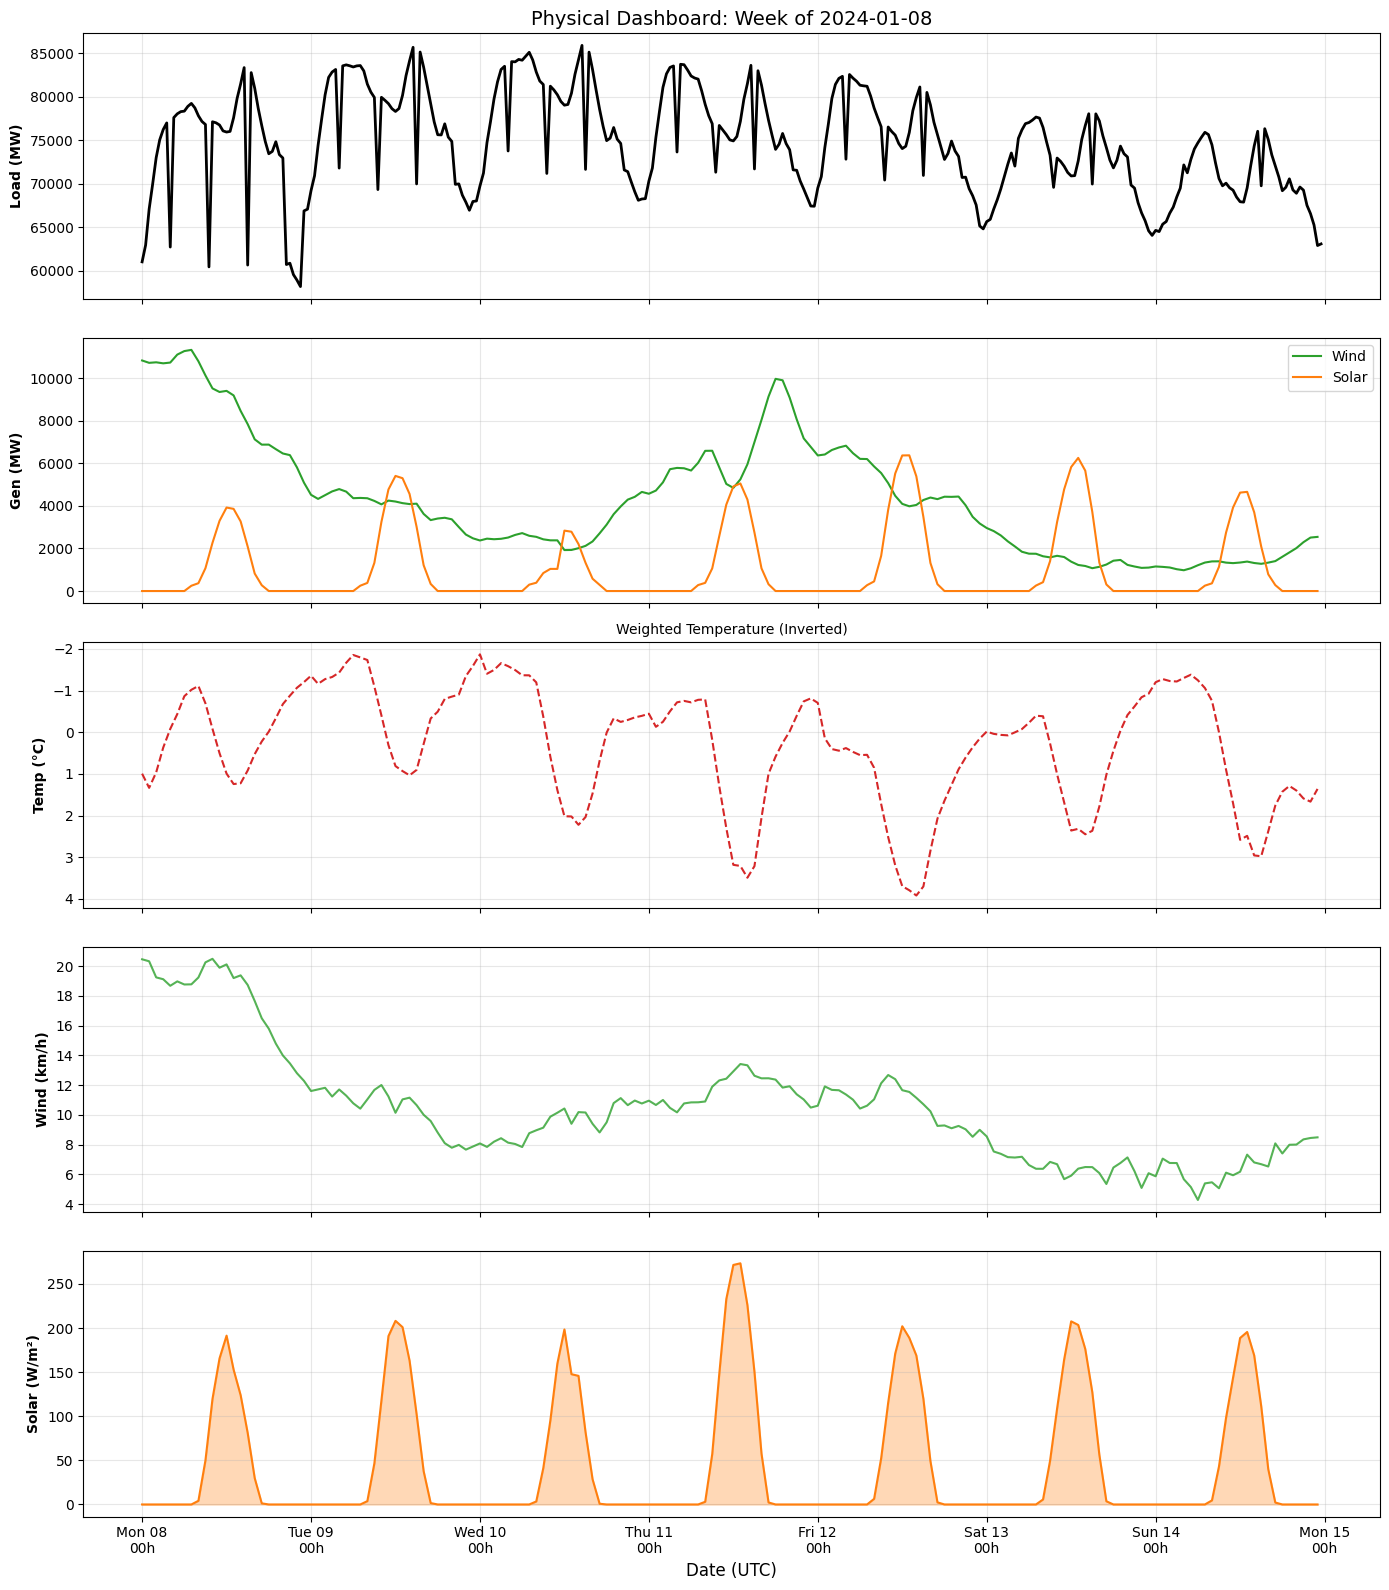

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==========================================
# 1. THE UNIVERSAL TIME FIX FUNCTION
# ==========================================
def load_and_standardize(filepath, col_date='datetime', source_type='auto'):
    """
    Robust loader that standardizes ANY time format to pure UTC.
    """
    df = pd.read_csv(filepath)
    
    # Normalize column name
    if col_date not in df.columns:
        for candidate in ['date', 'start_date', 'Date', 'datetime']:
            if candidate in df.columns:
                df.rename(columns={candidate: col_date}, inplace=True)
                col_date = 'datetime' # standardized name
                break
    
    # Parse initial
    df[col_date] = pd.to_datetime(df[col_date])
    
    # Convert to UTC based on source type
    if source_type == 'rte_historical' or (source_type == 'auto' and df[col_date].dt.tz is None):
        # Local Paris Time -> UTC (Handling DST)
        df['datetime_utc'] = df[col_date].dt.tz_localize(
            'Europe/Paris', ambiguous='NaT', nonexistent='shift_forward'
        ).dt.tz_convert('UTC')
    else:
        # Already Aware/UTC -> UTC
        df['datetime_utc'] = df[col_date].dt.tz_convert('UTC')
        
    return df.dropna(subset=['datetime_utc']).sort_values('datetime_utc')

# ==========================================
# 2. CONFIGURATION & DATA LOADING
# ==========================================
target_start = '2024-01-08' # Monday
target_end   = '2024-01-14' # Sunday

print("--- Loading & Standardizing Data ---")

# A. Load Population Weights
df_agglo = pd.read_csv('../data/external/agglomerations.csv')
weights_map = dict(zip(df_agglo['Agglomération'], 
                       df_agglo['Population AU 2017'] / df_agglo['Population AU 2017'].sum()))

# B. Load Weather (Already UTC)
df_weather = load_and_standardize('../data/raw/weather/weather_32_cities_2024.csv', col_date='date', source_type='weather')
df_weather['weight'] = df_weather['city'].map(weights_map)

# Compute National Weighted Weather
def weighted_avg(x):
    return pd.Series({
        'temp_nat': np.average(x['temperature_2m'], weights=x['weight']),
        'wind_nat': np.average(x['wind_speed_10m'], weights=x['weight']),
        'solar_nat': np.average(x['direct_radiation'] + x['diffuse_radiation'], weights=x['weight'])
    })
df_weather_nat = df_weather.groupby('datetime_utc').apply(weighted_avg).reset_index()

# C. Load Consumption (RTE - Naive Paris Time)
df_load = load_and_standardize('../data/interim/consommation/consommation_2024_long.csv', col_date='datetime', source_type='rte_historical')

# D. Load Production (RTE - Naive Paris Time)
df_prod = load_and_standardize('../data/interim/production/production_realisation_2024_long.csv', col_date='datetime', source_type='rte_historical')

# Pivot Production to Wide Format (Columns: Wind, Solar)
df_prod_wide = df_prod.pivot_table(index='datetime_utc', columns='technology', values='value_mw', aggfunc='sum').reset_index()
# Handle variable naming (generic search for Wind/Solar columns)
cols_wind = [c for c in df_prod_wide.columns if 'olien' in c or 'WIND' in c]
cols_solar = [c for c in df_prod_wide.columns if 'Solaire' in c or 'SOLAR' in c]
df_prod_wide['Wind_Total'] = df_prod_wide[cols_wind].sum(axis=1) if cols_wind else 0
df_prod_wide['Solar_Total'] = df_prod_wide[cols_solar].sum(axis=1) if cols_solar else 0

# ==========================================
# 3. FILTERING FOR THE DASHBOARD WEEK
# ==========================================
t_start = pd.to_datetime(target_start).tz_localize('UTC')
t_end   = pd.to_datetime(target_end).tz_localize('UTC') + pd.Timedelta(hours=23, minutes=59)

# Filter all dataframes
df_l_week = df_load[(df_load['datetime_utc'] >= t_start) & (df_load['datetime_utc'] <= t_end)]
df_p_week = df_prod_wide[(df_prod_wide['datetime_utc'] >= t_start) & (df_prod_wide['datetime_utc'] <= t_end)]
df_w_week = df_weather_nat[(df_weather_nat['datetime_utc'] >= t_start) & (df_weather_nat['datetime_utc'] <= t_end)]

# ==========================================
# 4. PLOTTING THE DASHBOARD
# ==========================================
fig, axes = plt.subplots(5, 1, figsize=(14, 16), sharex=True)

# 1. Consumption
axes[0].plot(df_l_week['datetime_utc'], df_l_week['load_mw'], color='black', linewidth=2)
axes[0].set_ylabel('Load (MW)', fontweight='bold')
axes[0].set_title(f'Physical Dashboard: Week of {target_start}', fontsize=14)
axes[0].grid(True, alpha=0.3)

# 2. Production (Wind + Solar)
axes[1].plot(df_p_week['datetime_utc'], df_p_week['Wind_Total'], label='Wind', color='#2ca02c') # Green
axes[1].plot(df_p_week['datetime_utc'], df_p_week['Solar_Total'], label='Solar', color='#ff7f0e') # Orange
axes[1].set_ylabel('Gen (MW)', fontweight='bold')
axes[1].legend(loc='upper right')
axes[1].grid(True, alpha=0.3)

# 3. Temperature (Inverted)
axes[2].plot(df_w_week['datetime_utc'], df_w_week['temp_nat'], color='#d62728', linestyle='--') # Red
axes[2].invert_yaxis() # Cold is UP (High Demand)
axes[2].set_ylabel('Temp (°C)', fontweight='bold')
axes[2].set_title('Weighted Temperature (Inverted)', fontsize=10)
axes[2].grid(True, alpha=0.3)

# 4. Wind Speed
axes[3].plot(df_w_week['datetime_utc'], df_w_week['wind_nat'], color='#2ca02c', alpha=0.8)
axes[3].set_ylabel('Wind (km/h)', fontweight='bold')
axes[3].grid(True, alpha=0.3)

# 5. Solar Radiation
axes[4].fill_between(df_w_week['datetime_utc'], 0, df_w_week['solar_nat'], color='#ff7f0e', alpha=0.3)
axes[4].plot(df_w_week['datetime_utc'], df_w_week['solar_nat'], color='#ff7f0e')
axes[4].set_ylabel('Solar (W/m²)', fontweight='bold')
axes[4].set_xlabel('Date (UTC)', fontsize=12)
axes[4].grid(True, alpha=0.3)

# X-Axis Formatting
axes[4].xaxis.set_major_formatter(mdates.DateFormatter('%a %d\n%Hh'))
axes[4].xaxis.set_major_locator(mdates.DayLocator())

plt.tight_layout()
plt.show()



This dashboard validates the physical synchronization of all datasets following the **UTC standardization**.

### 1. Consumption (Load)
* **Winter Profile:** High demand ranging from **60 GW to 85 GW**, driven by cold temperatures (-1°C to +4°C).
* **Cyclicality:** Clear "double hump" structure on weekdays (morning/evening peaks) and a significant demand drop on the weekend (Jan 13–14).

### 2. Renewable Generation vs. Physics
The alignment confirms that time lags have been eliminated:
* **Wind (Green):** Perfect correlation with wind speed. Generation peaks on Jan 8 (>10 GW) and collapses mid-week as wind speed drops to ~8 km/h.
* **Solar (Orange):** No lag observed. 

### 3. Thermosensitivity
* **Correlation:** The inverted temperature curve (Panel 3) visually mirrors the load curve (Panel 1).
* **Conclusion:** The data confirms the strong dependency between cold drops and load spikes (electric heating). The **UTC index is reliable** for modeling.

# 1. Reproducibility


## 1.1 Data sources


Document:
- RTE : 
https://www.services-rte.com/en/download-data-published-by-rte.html?category=consumption&type=power_consumption

https://www.services-rte.com/en/download-data-published-by-rte.html?category=generation&type=installed_capacities&subType=capacities_per_production_type (above 1MW)

API for almost real time (yesterday until 00h) : https://data.rte-france.com/group/guest/apps/-/apps/2473352/smart-grid-project# (i will sent you the ID by mail for more safety) (or an account can be crated in two minutes)

- Weather sources : 
https://open-meteo.com/en/docs/meteofrance-api for forecasts and
https://open-meteo.com/en/docs/historical-weather-api for past years

- datat.gouv for the cities and maps for coordinates 


# 2. Time axis integrity (global)


### Time alignment and UTC normalization

The original datasets were generated using heterogeneous time conventions:  
some historical series were stored as naive local timestamps (implicitly Europe/Paris),
while others (weather and near real-time APIs) were already timezone-aware.

This heterogeneity caused inconsistencies during exploratory analysis, especially around
daylight saving time transitions, where the same local hour (e.g. 02:00) may occur twice.
Such ambiguities lead to duplicated timestamps and alignment errors when combining
consumption, production, and weather data.

To ensure a consistent and robust temporal framework, **all time series have been
systematically converted to UTC**. Historical naive timestamps were first interpreted as
local Europe/Paris time and then converted to UTC, with explicit handling of daylight
saving time ambiguities. As a result, all datasets now share a unique, monotonic UTC
timeline, which simplifies data alignment, visualization, and subsequent modeling.



## 2.1 Frequency audit


Analyze datetime differences:
- Distribution of time deltas
- Abnormal steps
- Largest gaps


## 2.2 Missing timestamps


- Build the expected full time grid
- Count missing timestamps
- Identify contiguous missing blocks (start / end / duration)


## 2.3 Daylight Saving Time (DST)


- Identify 23-hour and 25-hour days
- Decide and document the timezone policy


# 3. Data quality and anomalies (global)


## 3.1 Missing values analysis


- Missing rate per variable
- Missingness over time (year / month)
- Optional heatmap


## 3.2 Outlier detection


- Extreme values in load and generation
- Negative or impossible values
- Flatlines and step changes


## 3.3 Known event windows


Inspect known periods:
- COVID shock
- Extreme cold spells
- Other major system events (if known)


# Part A — Consumption (demand side)


# 4. National electricity load: global behavior


## 4.1 Long-term trend


- Multi-year load evolution
- Rolling averages
- Non-stationarity discussion


## 4.2 Load distribution and tails


- Histogram / density
- Quantiles
- Extreme demand days


# 5. Intra-day and intra-week patterns (load)


## 5.1 Daily profile


- Average load by hour
- Weekday vs weekend comparison


## 5.2 Weekly structure


- Mean load by weekday
- Hourly profiles for each weekday


# 6. Seasonal patterns (load)


## 6.1 Monthly seasonality


- Monthly averages
- Monthly boxplots


## 6.2 Year-to-year comparison


- Same-month comparisons across years
- Structural break detection


# 7. Thermo-sensitivity analysis


## 7.1 Load vs temperature


- Scatter plots
- Nonlinear smoothing
- Winter vs summer asymmetry


## 7.2 Degree-days


- Heating Degree Days (HDD)
- Cooling Degree Days (CDD)
- Comparison with raw temperature


## 7.3 Thermal inertia


- Lagged or smoothed temperature features


# Part B — Production (supply side)


# 8. Electricity generation: overview


## 8.1 Total generation vs load


- Compare total generation and load
- Identify stress periods (imports/exports if available)


## 8.2 Generation mix


- Average mix by technology
- Mix evolution over time


# 9. Production by technology


## 9.1 Nuclear


- Stability
- Seasonal modulation
- Ramp constraints


## 9.2 Wind


- Volatility
- Seasonal behavior
- Ramp rates


## 9.3 Solar


- Diurnal cycle
- Seasonal amplitude


## 9.4 Hydro and thermal


- Dispatchable role
- Response during stress periods


# 10. Weather dependence (production)


## 10.1 Wind vs wind speed


- Scatter plots
- Binned averages


## 10.2 Solar vs radiation


- Scatter plots
- Solar vs hour of day


## 10.3 Seasonal weather effects


- Winter vs summer comparisons


# 11. Residual load and grid stress


## 11.1 Definition


Residual load = load − (wind + solar)


## 11.2 Residual load analysis


- Distribution
- Daily profile
- Extreme peaks


## 11.3 Comparison with raw load


- Tail behavior
- Interpretation for grid stress


# Cross-cutting analysis


# 12. Calendar effects


## 12.1 Weekday effects


- Mean differences by weekday
- Interaction with seasonality


## 12.2 Holidays and vacations


- Holiday vs non-holiday comparison
- Vacation-period effects


# 13. Temporal dependence


## 13.1 Autocorrelation


- ACF / PACF for load and residual load


## 13.2 Lag correlations


- Correlation at 24h, 48h, 168h


# 14. Feature relationships


## 14.1 Correlation heatmaps


- Load, weather, generation variables


## 14.2 Redundancy checks


- Multicollinearity inspection


# 15. EDA synthesis and modeling decisions


## 15.1 Main conclusions


Summarize confirmed patterns:
- Seasonality
- Nonlinearity
- Intermittency
- Temporal dependence


## 15.2 Modeling implications


- Target choice
- Feature set
- Data cleaning policy
- Backtesting strategy


# Appendix
